In [1]:
# 1) Random sampling (torch.randn, torch.rand, torch.distributions module)
# 2) Demonstration of central limit theorem through simulation
# 3) Autodiff and computational graph construction (grad fields for tensors, backward method (and how it discards the implicitly created computational graph), optimizers, loss functions)
# 4) Application of autodiff to a very simple problem (like fitting a normal and/or a beta distribution through maximum likelihood)

In [2]:
%matplotlib inline  
import torch
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Generating some data
In order to do this lab you're gonna need some data. Usually I wouldn't suggest doing this but why don't we just make up our data. Using PyTorch's __[built in distribution sampling functions](https://pytorch.org/docs/stable/distributions.html)__ create a dataset sampled from a Bernoulli, and another dataset sampled from a normal distribution

## Sampling from a normal distribution
First, draw a sample from a normal distribution using the parameters below. Story your data in the variable named `X_norm`, and print out the sample mean and standard deviation

In [3]:
trueMu = 1.491# mean
trueSig = 0.1876# standard deviation
nNormal = 10
#### your code here ####
normalDist = torch.distributions.normal.Normal(loc = trueMu, scale = trueSig)
X_norm = normalDist.sample(sample_shape = [nNormal,])
print("Inaccurate sample mean: {}, sample std: {}".format(X_norm.mean(), np.std(torch.Tensor.numpy(X_norm))))

Inaccurate sample mean: 1.5726956129074097, sample std: 0.2193295955657959


How close are the sample estimates of the mean and standard deviation to the true values? How can you improve the sample estimation of these values? What is the theorem that backs up your answer? Please describe how you might do that below and then implement your solution. Continue to store your data in the variable `X_norm`.

Note, we care more about you explaining that you know what you're doing, rather than how close you can get your estimates. 
### 1) Your answer here

In [4]:
#### your code here ####
nNormal = 10000
X_norm = normalDist.sample(sample_shape = [nNormal,])
print("More accurate sample mean: {}, sample std: {}".format(X_norm.mean(), np.std(torch.Tensor.numpy(X_norm))))

More accurate sample mean: 1.4929146766662598, sample std: 0.18604473769664764


## Binary data generation
Follow the same steps as above, but instead of a normal distribution we want binary data. What distribution can you use to sample binary data? Please ensure that the sample estimate probability of seeing a value of `1` is close to `trueP` 

In [5]:
trueP = 0.23
nBinary = 10000
#### your code here ####
bern = torch.distributions.bernoulli.Bernoulli(torch.tensor([trueP]))
X_bin = bern.sample(sample_shape = [nBinary,])
print("Sample estimate P(1): {}".format(X_bin.mean()))

Sample estimate P(1): 0.2287999987602234


# Part 2: Maximum Likelihood Estimation
You'll be learning more about maximum likelihood estimation (MLE) next week, but you'll have a chance to gain some intuition, and see how one can implement MLE here.

In the previous section you learned how more data can help you estimate the parameters of distributions that observations are drawn from. In the example of data drawn from a normal distribution it's intuitive how we can estimate the mean and standard deviation which parameterize the distribution which generated the data. Put another way, given the data we've seen and an idea for the function which generated this data (ie a normal distribution) we want find the parameters that likely describe how this data was generated. 

Let's examine some of the moving parts. We have some data, $X \in R^{n}$, and we know that each observation $x^{i}$ was generated with probability defined by $f(x^{i}|\theta)$ where $\theta$ are the parameters that help us define this function. I know this is a little handwavy but just bear with me here. You'll get a better theoretical understanding in class. Let's look at the example of the normal distribution as a data generating function. Here $f(x^{i}|\theta) = f(x^{i}|\mu, \sigma) = \frac{1}{2\pi\sigma^2}exp(-\frac{(x^{i}-\mu)^2}{2\sigma^2})$ which isthe probability density function of the __[normal distribution](https://en.wikipedia.org/wiki/Normal_distribution)__. 

So that's the probability of observing one $x^i$, but what about all $n$ of those dudes? Well since we're dealing with indpendently and identically distributed data we just multiply that function over and over to get the likelihood of observing our data. That is $f(X|\mu, \sigma) = \prod_{i = 1}^{n}f(x^{i}|\mu, \sigma) = \frac{1}{2\pi\sigma^2}^{\frac{n}{2}}exp(-\frac{\sum_{i=1}^{n}(x^{i}-\mu)^2}{2\sigma^2})$

Ok, so that was alot. But essentially we're just deriving the probability of seeing all our data. The next and final step is to take the log of the final equation above. We do this because of numerical stability. When you're dealing with small numbers, like fractions, repeatedly muliplying them can lead to underflow. $$L(X|\mu, \sigma) = \frac{-n}{2}log(2\pi\sigma^2) - \frac{1}{2\pi\sigma^2}\sum_{i=1}^{n}(x^i - \mu)^2$$

During MLE our goal is to find the parameters $\theta$ which maximize the function $L(X|\theta)$. In the cell below fix $\sigma$ at the true value of `0.1876` and calculate the likelihood function for the data observed with varied $\mu$ between 1 and 2 with a step size of 0.05. Which value of $\mu$ maximizes the function?

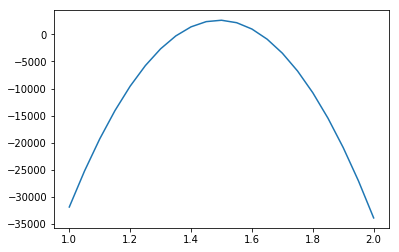

In [7]:
#### your code here ####
muList = np.arange(1, 2.05, 0.05)
logLikList = []
n = X_norm.shape[0]
for mu in muList:
    logLik = (-(n/2)*np.log(2*np.pi*(trueSig**2)) - (1/(2*(trueSig**2)))*np.sum((X_norm.data.numpy() - mu)**2))
    logLikList.append(logLik)
plt.plot(muList, logLikList)
plt.show()

## MLE: Normal
So from above we can see that at the true values of $\sigma$ and $\mu$ the log likelihood is maximized. How can we learn what these parameters should be in order to maximize the MLE? With a little PyTorch and gradient descent we can do just that.

In [10]:
# Instantiate the parameters to learn. Notice how requires_grad is set to true. This is because we want
# to update this parameter with the the MLE.
learnedMu = torch.autograd.Variable(torch.rand(1), requires_grad = True)
learnedSigma = torch.autograd.Variable(torch.rand(1), requires_grad = True)
print("Initial Mu: {}".format(learnedMu))
print("Initial Sigma: {}".format(learnedSigma))


# This says how big of a step should we take each time we update our parameters.
# there is some instability in the updates, so you might have to run a couple of times to get
# values that look like what they should be.
learningRate = 0.000001
# learnedProb.zero_()
n = X_norm.shape[0]
for myIter in range(1000):
    #Instantiate the MLE for a normal distribution here using torch functions.
    #### your code here ####
    MLE = -((n/2)*torch.log(2*np.pi*(learnedSigma**2)) + (1/(2*(learnedSigma**2)))*torch.sum((X_norm - learnedMu)**2))
    #### end code here ####
    MLE.backward()
    # Now we run over the data multiple times, and each time we calculate how far away we are from
    # the maximized MLE and update our parameters accordingly
    if myIter % 100 == 0:
        print("log likelihood: {}, learned mu = {}, learned sigma {}".format(MLE.data.numpy(),
                                                                          learnedMu.data.numpy(),
                                                                          learnedSigma.data.numpy()))
    # SGD update for our learned parameters
    learnedMu.data = learnedMu.data + learnedMu.grad.data*learningRate
    learnedSigma.data = learnedSigma.data + learnedSigma.grad.data*learningRate
    # Clear out the gradient information
    learnedMu.grad.data.zero_()
    learnedSigma.grad.data.zero_()

Initial Mu: tensor([0.5265], requires_grad=True)
Initial Sigma: tensor([0.1850], requires_grad=True)
log likelihood: [-133777.72], learned mu = [0.52654177], learned sigma [0.18501782]
log likelihood: [-10645.307], learned mu = [1.0949963], learned sigma [1.0618695]
log likelihood: [2628.2944], learned mu = [1.4929128], learned sigma [0.18604474]
log likelihood: [2628.2954], learned mu = [1.4929147], learned sigma [0.18604474]
log likelihood: [2628.2954], learned mu = [1.4929147], learned sigma [0.18604474]
log likelihood: [2628.2954], learned mu = [1.4929147], learned sigma [0.18604474]
log likelihood: [2628.2954], learned mu = [1.4929147], learned sigma [0.18604474]
log likelihood: [2628.2954], learned mu = [1.4929147], learned sigma [0.18604474]
log likelihood: [2628.2954], learned mu = [1.4929147], learned sigma [0.18604474]
log likelihood: [2628.2954], learned mu = [1.4929147], learned sigma [0.18604474]


## MLE: Bernoulli
Finally, using the binary data we generated using a Bernoulli distribution let's learn the true value for $p$. Similarly to the above formulation you'll need to create a parameter to learn, as well as define the MLE for our binary data.

In [13]:
# Define the variable p variable to learn
#### your code here ####
learnedP = torch.autograd.Variable(torch.rand(1), requires_grad = True)
#### end code here ####
# Once again, running this can be a little temperamental, so if you're not getting the right answer
# run it a few more times just ot be sure
learningRate = 0.00001
for myIter in range(1000):
    # define the MLE for iid data from a Bernoulli
    #### your code here ####
    MLE = torch.sum(torch.log(X_bin*learnedP + (1-X_bin)*(1-learnedP)))
    #### end code here ####
    MLE.backward()
    if myIter % 100 == 0:
        print("log likelihood: {}, learned prob = {}, update = {}".format(MLE.data.numpy(),
                                                                          learnedP.data.numpy(),
                                                                          learnedP.grad.data.numpy()))
    # Update your learned parameter with a gradient descent step (similar to the normal case)
    #### your code here ####
    learnedP.data = learnedP.data + learnedP.grad.data*learningRate
    #### end code here ####
    learnedP.grad.data.zero_()

log likelihood: -5757.607421875, learned prob = [0.356143], update = [-5553.4194]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
log likelihood: -5378.24267578125, learned prob = [0.22880003], update = [0.]
